First run I will do without any filtering, that might come later after a deeper investigation in possible filters.

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Filter gt for biallelic sites

In [4]:
ac = gt.count_alleles()[:] #Allele counts for each pos
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filter for biallelic and presence of alternate
gf = gt.compress(flt, axis=0)
pos = (callset["variants/POS"][:]).compress(flt, axis=0)
print(len(gf), len(gt), len(gf)/len(gt))

2560187 2923212 0.8758129755898648


First, I am going to find shared derived between Species, and then between the clustered origins.
First for the whole X (including PAR here), then for regions

In [5]:
id_dir = {}
for s in meta_data_samples.Species.unique():
    IDs = meta_data_samples.loc[(meta_data_samples.Species == s)
                                      & (meta_data_samples.Sex == "F")].callset_index.values
    if len(IDs) != 0:
        id_dir[s] = IDs

In [6]:
id_dir

{'cynocephalus': array([  0,   1,  24,  25,  27,  35,  36,  37,  43,  48,  61,  62,  63,
         87, 104, 105, 177, 186, 197, 201, 202, 204, 205, 206]),
 'anubis': array([  3,  10,  11,  14,  16,  17,  19,  20,  21,  22,  23,  30,  32,
         33,  49,  50,  51,  52,  54,  55,  56,  76,  79,  83,  84,  85,
         90,  91,  93,  95,  97,  99, 100, 101, 106, 107, 108, 109, 110,
        112, 114, 115, 117, 118, 153, 156, 158, 162, 168, 169, 170, 176]),
 'kindae': array([  4,   5, 192, 213, 220, 221, 222, 223, 224]),
 'hamadryas': array([  7, 130, 132, 133, 140, 142]),
 'papio': array([64, 65, 66, 67, 68]),
 'ursinus (grayfoot)': array([125, 126, 127])}

Creating the dataframe and populating it

In [7]:
df_species = pd.DataFrame()
df_species["pos"] = pos
for species in id_dir:
    print(species)
    IDs = id_dir[species]
    gt_species = gf.take(IDs, axis=1)
    ac = gt_species.count_alleles()
    df_species[species] = ac.is_variant()
    print(ac.is_variant().sum())

cynocephalus
1019939
anubis
774523
kindae
578411
hamadryas
355074
papio
185075
ursinus (grayfoot)
410758


Number of sites with no derived (due to males having derived calls)

In [8]:
print((df_species.iloc[:,1:].sum(axis=1) == 0).sum()/len(df_species))

0.3162847088904053


Looking at the distribution of derived sites

In [9]:
df_species["species_derived"] = df_species.iloc[:,1:].sum(axis=1)

In [10]:
df_species["species_derived"].value_counts()

1    1017001
0     809748
2     350501
3     138023
4     107731
6      74869
5      62314
Name: species_derived, dtype: int64

<AxesSubplot:xlabel='species_derived', ylabel='Count'>

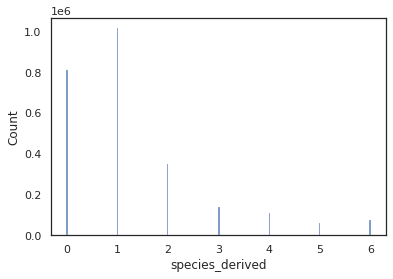

In [11]:
sns.histplot(df_species, x="species_derived")

In [12]:
df_species_r = df_species.loc[df_species.species_derived != 6]

In [13]:
d_d = {}
for s1 in id_dir:
    d_d[s1] = {}
    for s2 in id_dir:
        d_d[s1][s2] =((df_species_r[s1]==True) & (df_species_r[s2]==True)).sum()
derived_df = pd.DataFrame(d_d)
derived_df

,cynocephalus,anubis,kindae,hamadryas,papio,ursinus (grayfoot)
cynocephalus,945070,378983,334387,108863,35106,241725
anubis,378983,699654,191323,144562,39903,160359
kindae,334387,191323,503542,78303,21021,200849
hamadryas,108863,144562,78303,280205,24353,61006
papio,35106,39903,21021,24353,110206,13353
ursinus (grayfoot),241725,160359,200849,61006,13353,335889


In [14]:
window_size = 100000
def shared_counting(shared):
    return shared.sum()

df_dict = {}
for s1 in id_dir:
    df_species_list = []
    for s2 in id_dir:
        chrom="chrX"
        shared =((df_species_r[s1]==True) & (df_species_r[s2]==True))
        pos_subset = pos.compress(df_species.species_derived != 6,axis=0)
        nnz, windows, counts = allel.windowed_statistic(pos_subset,
                                                        shared, statistic=shared_counting, size=window_size)
        df = pd.DataFrame()
        df["shared"] = nnz
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = s2)
        df_species_list.append(df)
    s1_df = pd.concat(df_species_list, axis=0)
    df_dict[s1] = s1_df

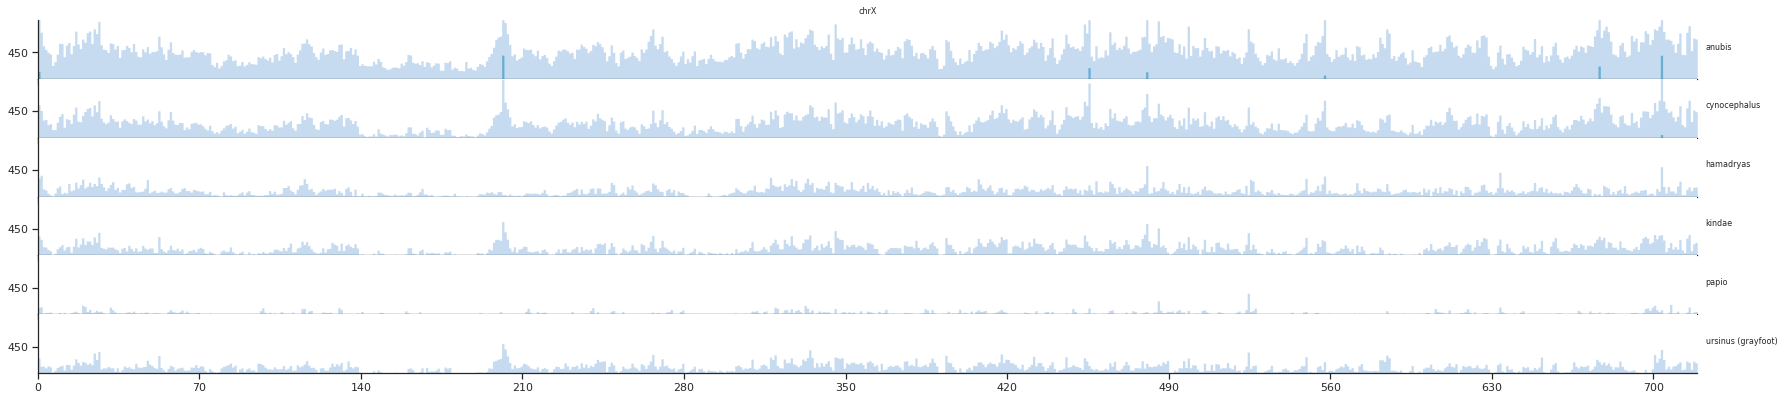

In [15]:
anubis = df_dict["anubis"]
anubis_first_half = anubis.loc[anubis.start <= max(anubis.start)//2]
fig = horizonplot(anubis_first_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

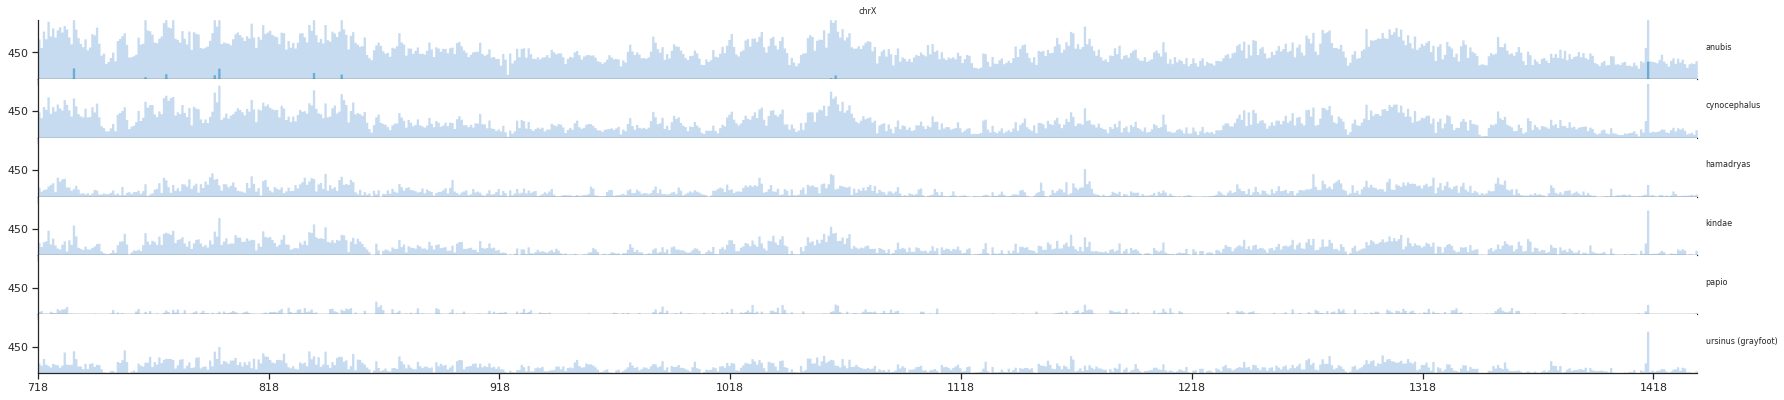

In [16]:
anubis = df_dict["anubis"]
anubis_second_half = anubis.loc[anubis.start >= max(anubis.start)//2]
fig = horizonplot(anubis_second_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

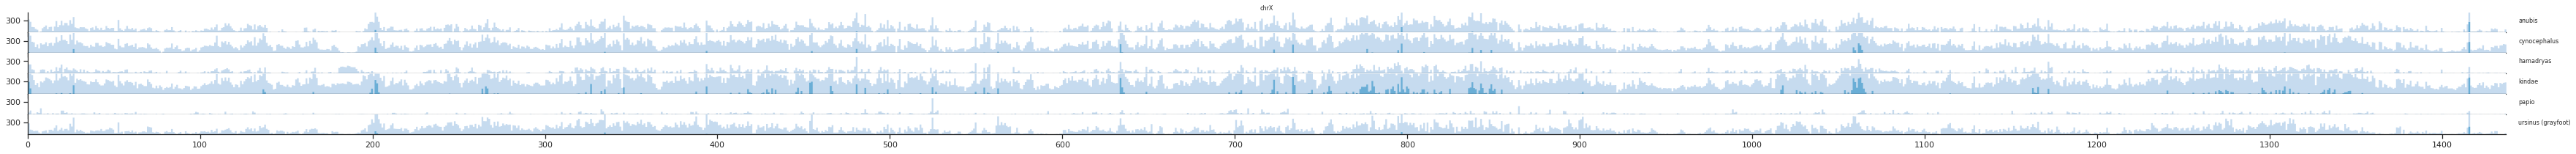

In [17]:
fig = horizonplot(df_dict["kindae"], 'shared', width=1, col='chrom', row='pop', size=0.5, aspect=100, cut=500)

Doing the same, but for the regions

In [18]:
id_dir_region = {}
for r in meta_data_samples.C_origin.unique():
    IDs = meta_data_samples.loc[(meta_data_samples.C_origin == r)
                                      & (meta_data_samples.Sex == "F")].callset_index.values
    if len(IDs) != 0:
        id_dir_region[r] = IDs

In [19]:
id_dir_region

{'Cynocephalus, Central Tanzania': array([  0,   1,  24,  25,  27,  35,  36,  37,  48,  61,  62,  63,  87,
        177, 186, 197, 201, 202, 204, 205, 206]),
 'Anubis, Kenya': array([3]),
 'Kindae, Zambia': array([  4,   5, 192, 213, 220, 221, 222, 223, 224]),
 'Hamadryas, Ethiopia': array([  7, 130, 132, 133, 140, 142]),
 'Anubis, Tanzania': array([ 10,  11,  14,  16,  17,  19,  20,  21,  22,  23,  30,  32,  33,
         49,  50,  51,  52,  54,  55,  56,  76,  79,  83,  84,  85,  90,
         91,  93,  95,  97,  99, 100, 101, 106, 107, 108, 109, 110, 112,
        114, 115, 117, 118]),
 'Cynocephalus, Western Tanzania': array([ 43, 104, 105]),
 'Papio, Senegal': array([64, 65, 66, 67, 68]),
 'Ursinus, Zambia': array([125, 126, 127]),
 'Anubis, Ethiopia': array([153, 156, 158, 162, 168, 169, 170, 176])}

In [20]:
df_region = pd.DataFrame()
df_region["pos"] = pos
for region in id_dir_region:
    print(region)
    IDs = id_dir_region[region]
    gt_region = gf.take(IDs, axis=1)
    ac = gt_region.count_alleles()
    df_region[region] = ac.is_variant()
    print(ac.is_variant().sum())
df_region["non_ref_sum"] = df_region.iloc[:,1:].sum(axis=1)

Cynocephalus, Central Tanzania
864233
Anubis, Kenya
147217
Kindae, Zambia
578411
Hamadryas, Ethiopia
355074
Anubis, Tanzania
650231
Cynocephalus, Western Tanzania
547103
Papio, Senegal
185075
Ursinus, Zambia
410758
Anubis, Ethiopia
310132


In [21]:
print((df_region.iloc[:,1:].sum(axis=1) == 0).sum()/len(df_region))

0.3162847088904053


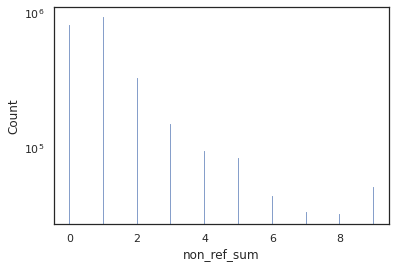

In [22]:
g = sns.histplot(df_region, x="non_ref_sum")
g.set_yscale("log")

In [23]:
len(df_region.loc[df_region.non_ref_sum ==3])

148951

In [24]:
len(df_region)

2560187

In [25]:
pd.DataFrame(df_region["non_ref_sum"].value_counts()).sort_index()

,non_ref_sum
0,809748
1,934214
2,328715
3,148951
4,94367
5,83912
6,43604
7,33542
8,31915
9,51219


In [26]:
df_region_r = df_region.loc[df_region.non_ref_sum != max(df_region.non_ref_sum)]

In [27]:
pd.set_option("display.precision", 2)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Kenya","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.00,1.00,43.00,21.00,3.00,6.00,9.00,5.00,3.00
Total non-ref,258913.00,95998.00,599012.00,813014.00,495884.00,303855.00,527192.00,133856.00,359539.00
"Anubis, Ethiopia",1.00,0.53,0.24,0.12,0.17,0.39,0.14,0.34,0.17
"Anubis, Kenya",0.20,1.00,0.14,0.06,0.08,0.14,0.06,0.14,0.08
"Anubis, Tanzania",0.55,0.88,1.00,0.44,0.51,0.46,0.39,0.46,0.50
"Cynocephalus, Central Tanzania",0.38,0.51,0.60,1.00,0.69,0.41,0.54,0.41,0.67
"Cynocephalus, Western Tanzania",0.32,0.41,0.42,0.42,1.00,0.35,0.60,0.36,0.61
"Hamadryas, Ethiopia",0.46,0.45,0.24,0.15,0.21,1.00,0.19,0.36,0.24
"Kindae, Zambia",0.29,0.34,0.35,0.35,0.63,0.34,1.00,0.33,0.62
"Papio, Senegal",0.18,0.19,0.10,0.07,0.10,0.16,0.08,1.00,0.10


In [28]:
window_size = 100000
def shared_counting(shared):
    return shared.sum()

df_dict = {}
for s1 in sorted(id_dir_region):
    df_species_list = []
    for s2 in sorted(id_dir_region):
        chrom="chrX"
        shared =((df_region_r[s1]==True) & (df_region_r[s2]==True))
        pos_subset = pos.compress(df_region_r.non_ref_sum != max(df_region.non_ref_sum),axis=0)
        nnz, windows, counts = allel.windowed_statistic(pos_subset,
                                                        shared, statistic=shared_counting, size=window_size)
        df = pd.DataFrame()
        df["shared"] = nnz
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = s2)
        df_species_list.append(df)
    s1_df = pd.concat(df_species_list, axis=0)
    df_dict[s1] = s1_df

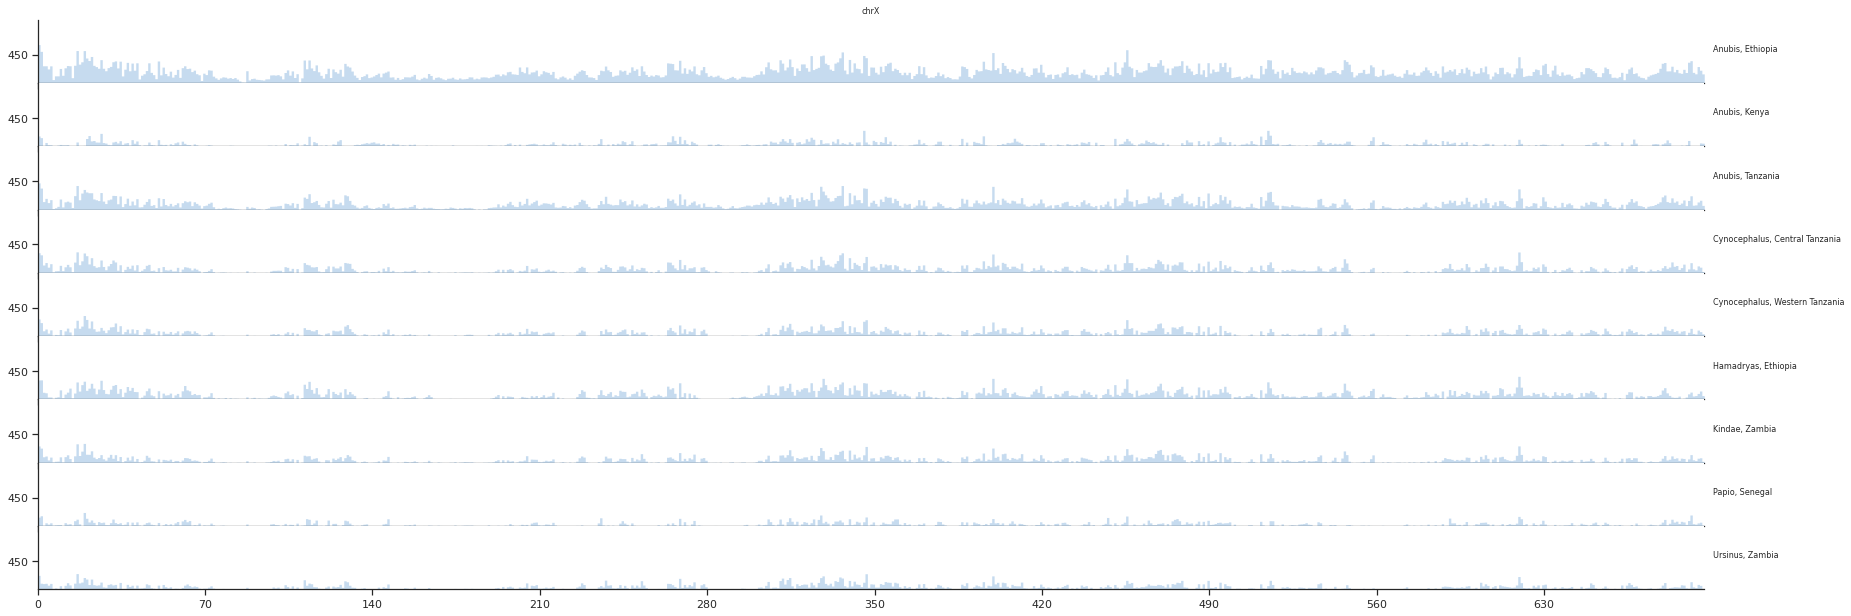

In [29]:
anubis = df_dict["Anubis, Ethiopia"]
anubis_first_half = anubis.loc[anubis.start <= max(anubis.start)//2]
fig = horizonplot(anubis_first_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

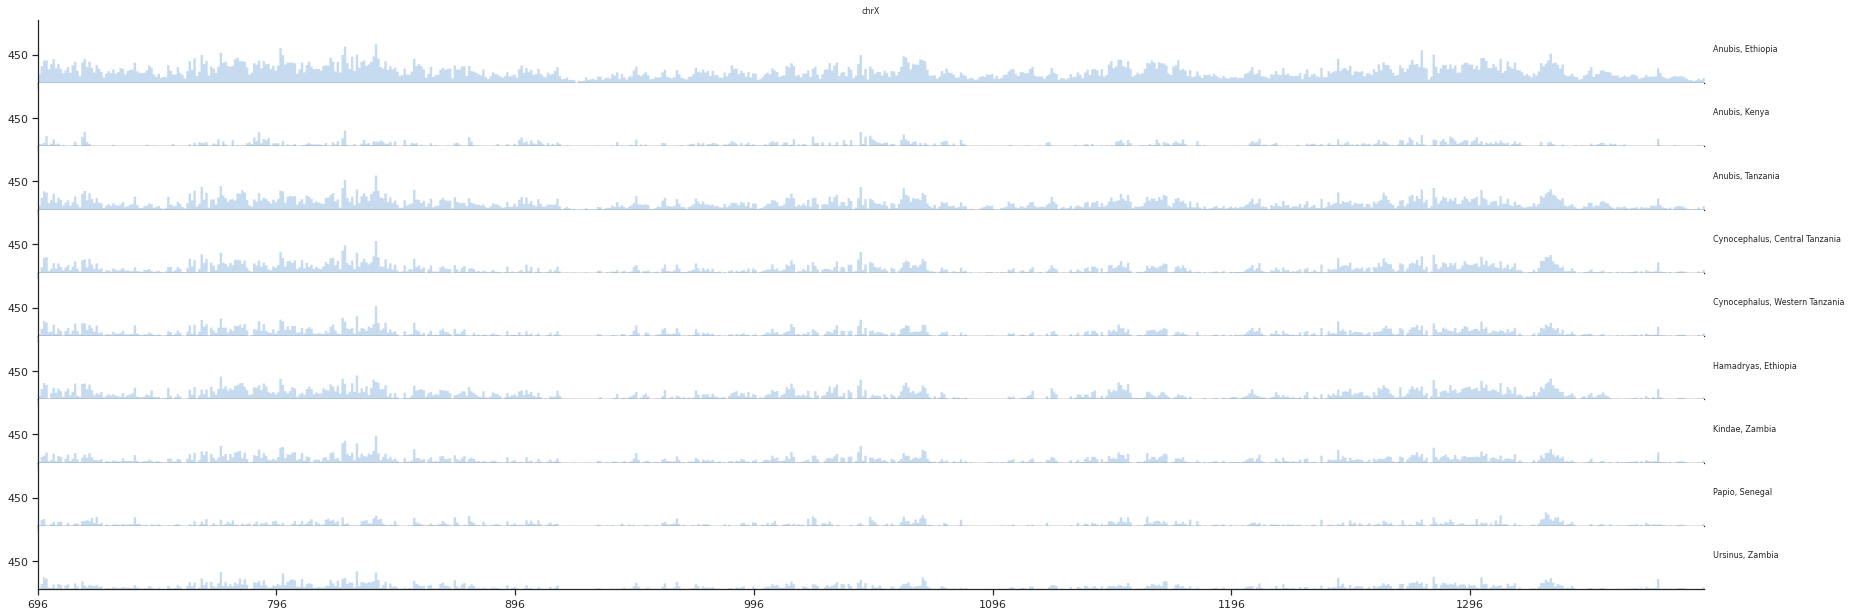

In [30]:
anubis = df_dict["Anubis, Ethiopia"]
anubis_second_half = anubis.loc[anubis.start >= max(anubis.start)//2]
fig = horizonplot(anubis_second_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

In [31]:
df_region_r = df_region.loc[df_region.non_ref_sum == 2]

In [32]:
df_region_r

,pos,"Cynocephalus, Central Tanzania","Anubis, Kenya","Kindae, Zambia","Hamadryas, Ethiopia","Anubis, Tanzania","Cynocephalus, Western Tanzania","Papio, Senegal","Ursinus, Zambia","Anubis, Ethiopia",non_ref_sum
6,240,False,False,True,False,True,False,False,False,False,2
17,551,True,False,False,False,True,False,False,False,False,2
21,597,False,False,False,False,True,False,False,False,True,2
23,622,True,False,False,False,True,False,False,False,False,2
34,1454,False,False,False,False,True,False,False,False,True,2
...,...,...,...,...,...,...,...,...,...,...,...
2560161,143688922,False,False,False,False,True,False,True,False,False,2
2560170,143690405,False,False,True,False,True,False,False,False,False,2
2560175,143691435,True,False,False,False,True,False,False,False,False,2
2560176,143691466,False,False,False,False,False,True,False,True,False,2


In [33]:
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Kenya","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.000,1.000,43.000,21.000,3.000,6.000,9.000,5.000,3.000
Total non-ref,42892.000,20744.000,146296.000,164331.000,107528.000,33412.000,90272.000,5453.000,46502.000
"Anubis, Ethiopia",1.000,0.101,0.125,0.011,0.004,0.560,0.007,0.112,0.006
"Anubis, Kenya",0.049,1.000,0.112,0.008,0.001,0.016,0.001,0.010,0.001
"Anubis, Tanzania",0.427,0.791,1.000,0.534,0.112,0.177,0.036,0.288,0.025
"Cynocephalus, Central Tanzania",0.041,0.066,0.599,1.000,0.371,0.098,0.153,0.198,0.332
"Cynocephalus, Western Tanzania",0.011,0.006,0.082,0.243,1.000,0.016,0.524,0.045,0.150
"Hamadryas, Ethiopia",0.436,0.025,0.040,0.020,0.005,1.000,0.032,0.199,0.011
"Kindae, Zambia",0.015,0.006,0.022,0.084,0.440,0.085,1.000,0.101,0.469
"Papio, Senegal",0.014,0.003,0.011,0.007,0.002,0.032,0.006,1.000,0.006


In [34]:
derived_df_region.iloc[1].sum()

657430.0

In [35]:
df_region_r = df_region.loc[(df_region.non_ref_sum <= 3) & (df_region.non_ref_sum >= 1)]

In [36]:
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Kenya","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.000,1.000,43.000,21.000,3.000,6.000,9.000,5.000,3.000
Total non-ref,150269.000,39288.000,354243.000,548512.000,249093.000,172030.000,297065.000,73349.000,154648.000
"Anubis, Ethiopia",1.000,0.239,0.114,0.012,0.011,0.186,0.006,0.030,0.006
"Anubis, Kenya",0.062,1.000,0.081,0.009,0.005,0.019,0.002,0.005,0.001
"Anubis, Tanzania",0.269,0.734,1.000,0.242,0.177,0.125,0.060,0.057,0.070
"Cynocephalus, Central Tanzania",0.045,0.130,0.375,1.000,0.421,0.053,0.206,0.036,0.265
"Cynocephalus, Western Tanzania",0.018,0.034,0.125,0.191,1.000,0.016,0.341,0.012,0.194
"Hamadryas, Ethiopia",0.213,0.083,0.061,0.017,0.011,1.000,0.018,0.031,0.012
"Kindae, Zambia",0.012,0.012,0.050,0.112,0.407,0.030,1.000,0.017,0.283
"Papio, Senegal",0.015,0.009,0.012,0.005,0.003,0.013,0.004,1.000,0.004
